# PSO IC&IT


## Imports 

In [2]:
!pip install control

import random
import math    
import copy    
import numpy as np
import matplotlib.pyplot as plt
from PID import PID

rnd = random.Random(100)

Defaulting to user installation because normal site-packages is not writeable


## Particula

In [3]:
class Particula:
  def __init__(self, dim, min, max):
    # definindo semente de aleatoriedade
    global rnd

    self.X = list()
    self.V = list()
    self.pbest = list()
    self.I = 1.0
    self.erro = 0

    # Criando valores de position, velocidade e melhor posição da particula (pbest)

    for i in range(dim):
      self.X.append((max - min) * rnd.random() + min)
      self.V.append((max - min) * rnd.random() + min)

    self.pbest = copy.copy(self.X) 


## Função 

In [4]:
def function(x, plot = False):
  '''
  Função que calcula a posição de cada uma das particulas
  '''
  # função de teste para dimensão 1
  # y = (12*(x[0] ** 5) - 975*(x[0] ** 4) + 28000*(x[0] ** 3) - 345000*(x[0] ** 2) + 1800000*x[0])/1000000
 
  #instancia o PID
  pid = PID(num = [16], den = [1,4,16])

  #saida do controlador e o erro do controlador
  y, error = pid.controller(x[0],x[1],x[2])
  
  #calcula erro absoluto do sistema
  error_sum = sum(abs(error))
  
  #plotagem caso desejado
  if plot:
    pid.plot(y, set_point = True)
    print(error_sum)


  return error_sum

## Plotando Sistema

In [5]:
def plotando_particulas(x,y,particulas,i,w,c1,c2, parada, dim):
  if(dim == 1):
    fig,ax = plt.subplots(figsize = (12,8))

    lin_plot = ax.plot(x[0],y)
    part_X = [particula.X for particula in particulas]
    X = [part_X[i][0] for i in range(len(particulas))]
    Y = [function(x) for x in part_X]

    

    plt.scatter(X,Y, marker='o', color='black', alpha=0.5)
    plt.plot(x[0],y, color='blue')

    plt.figtext(0.125,0.95 , f'Fator de inercia: {w} coeficiente cognitivo: {c1} coeficiente social: {c2} ',
                fontsize = 15,fontname = 'monospace', color = '#283655')
    plt.figtext(0.125,0.90 , f'Critério de parada: {parada} Iteração: {i}',
                fontsize = 15,fontname = 'monospace', color = '#283655')

    fig.canvas.draw()
    
    plt.show()

    return fig
  
  elif(dim == 2):
    pass

## Plot PID

In [6]:
def plot_pid(X,pid_param):
  erro = list()

  pid = Pid(pid_param[0],pid_param[1],set_point = pid_param[2])
  y, _, _ = pid.controller(X[0],X[1],X[2])
  p1, p2 = Tempo_Subida(X, pid_param)

  erro.append(ISE(X, pid_param))
  erro.append(IAE(X, pid_param))
  erro.append(ITSE(X, pid_param))
  erro.append(Tempo_Acomodacao(X, pid_param))
  erro.append(p1)
  erro.append(p2)
  erro.append(Overshoot(X, pid_param))

  pid.plot(y,erro, temp_plot = 20.0)

## PID

In [7]:
def Pid(num, den, set_point):  
  '''
  Esta funçao cria um PID com determinados parametros
  e devolve varios tipos de erro
  '''
 
  #instancia o PID
  pid = PID(num = num,den = den, set_point = set_point)

  return pid

## Criando os passarinhos

In [8]:
def inicializate(n_part, dim, min, max, n_points = 500):
  '''
  incializa as particulas com valores aleatórios
  entre o minimo e o maximo determinado
  '''

  particulas = [Particula( dim, min, max) for i in range(n_part)]

  return particulas


## Atualizando particula

In [9]:
def updating_particle(particula ,min ,max, dim):
  '''
  Função que atualiza a posição da particula
  '''
  for i in range(dim):
    particula.X[i] = particula.X[i] + particula.V[i]

    if particula.X[i] > max:
      particula.X[i] = max

    elif particula.X[i] < min:
      particula.X[i] = min
    
  return particula

## Atualizando velocidade

In [10]:
def updating_velocity(particula ,w ,c1 ,c2 ,g_best ):
  '''
  Função que atualiza a velocidade da particula
  '''
  rnd = random.Random(100)
  
  for i in range(dim):
    prim = w*particula.V[i]
    seg =  c1*rnd.random()*(particula.pbest[i] - particula.X[i])
    terc = c2*rnd.random()*(g_best[i]-particula.X[i])

    new_velocity = prim + seg + terc

    particula.V[i] = new_velocity

  return particula

## Atualizando pbest

In [11]:
def updating_pbest(particula, pid_param):
  '''
  Função que atualiza o pbest, ou seje, o ponto 
  com o melhor resultado entre todos os pontos ja
  percorridos por dada particula. O melhor resultado
  depende se o problema é de minimização ou maximização.
  '''

  pid = Pid(pid_param[0], pid_param[1], set_point = pid_param[2])


  if particula.erro < ISE(particula.pbest, pid_param):
    particula.pbest = particula.X.copy()

  return particula

## Atualizando improvement

In [12]:
def updating_improvement(particula ,w ,c1 ,c2 ,g_best,dim ,min, max, pid):
  
  particula.I = ISE(particula.pbest, pid_param) - ISE(particula.X, pid_param)

  # print(f'particula.I : {particula.I}')
  # print(f'ise posição atual: {ISE(particula.X, pid_param)} , ise pbest {ISE(particula.pbest, pid_param)}')

  return particula

## Atualizando gbest

In [13]:
def updating_gbest(particulas, pid_param):
  '''
  Função que atualiza o gbest, ou seje, o ponto 
  com o melhor resultado entre as particulas. O
  melhor resultado depende se o problema é de 
  minimização ou maximização.
  '''
  
  resultados = [particula.erro for particula in particulas]

  erro_min = np.min(resultados)
  arg_min = np.argmin(resultados)

  g_best = particulas[arg_min].X.copy()

  return g_best

## ISE


In [14]:
def ISE(particula, pid_param):
  pid = Pid(pid_param[0],pid_param[1],set_point = pid_param[2])

  if type(particula) == list:
    try:
      _, erro, _ = pid.controller(particula[0],particula[1],particula[2])
      erro = sum(erro ** 2)
      return erro

    except:
      particula = [round(i) for i in particula]
      _, erro, _ = pid.controller(particula[0],particula[1],particula[2])
      erro = sum(erro ** 2)
      return erro

  else:
    _, particula.erro, _ = pid.controller(particula.X[0],particula.X[1],particula.X[2])
    particula.erro = sum(particula.erro ** 2)
    # print(f'particula.erro : {particula.erro:,.2f} posição: {particula.X} pbest {particula.pbest}' )
    return particula

## IAE

In [15]:
def IAE(particula, pid_param):
  pid = Pid(pid_param[0],pid_param[1],set_point = pid_param[2])

  if type(particula) == list:
    try:
      _, erro, _ = pid.controller(particula[0],particula[1],particula[2])
      erro = sum(abs(erro))
                 
      return erro

    except:
      particula = [round(i) for i in particula]
      _, erro, _ = pid.controller(particula[0],particula[1],particula[2])
      erro = sum(abs(erro))
      return erro

  else:
    _, particula.erro, _ = pid.controller(particula.X[0],particula.X[1],particula.X[2])
    particula.erro = sum(abs(particula.erro))
    # print(f'particula.erro : {particula.erro:,.2f} posição: {particula.X} pbest {particula.pbest}' )
    return particula

## ITSE

In [16]:
def ITSE(particula, pid_param):

  pid = Pid(pid_param[0],pid_param[1],set_point = pid_param[2])

  if type(particula) == list:
    try:
      _, erro, temp = pid.controller(particula[0],particula[1],particula[2])
      erro = sum(temp * (erro ** 2))
                 
      return erro

    except:
      particula = [round(i) for i in particula]
      _, erro, temp = pid.controller(particula[0],particula[1],particula[2])
      erro = sum(temp * (erro ** 2))
      return erro

  else:
    _, particula.erro, temp = pid.controller(particula.X[0],particula.X[1],particula.X[2])
    particula.erro = sum(temp * (erro ** 2))
    # print(f'particula.erro : {particula.erro:,.2f} posição: {particula.X} pbest {particula.pbest}' )
    return particula

## Atualizando Sistema

In [17]:
def update_sistem(particulas ,min ,max ,w , c1, c2, parada, dim, pid_param):
  '''
  Função responável por atualizar todo o sistemas
  do PSO
  '''
  sem_melhoras = 0
    
  n_iter = 1

  particulas = [ISE(particula, pid_param) for particula in particulas]

  g_best = updating_gbest(particulas, pid_param).copy()

  while(True):

    if (sem_melhoras > 0):
      print(f"\nSem melhoras á {sem_melhoras} iterações\n")

    if (sem_melhoras == 5):
      print(f'< Critério de parada atingido, o sistemas não teve melhoras significativas a 5 iterações. >')
      print(f'< {n_iter} iterações antes de atingir o critério. >')
      break


    # for particula in particulas:
    #   print(f'Posição da particula: {particula.X[0]:,.3f} , {particula.X[1]:,.3f} , {particula.X[2]:,.3f}')
    #   print(f'velocidade da particula: {particula.V[0]:,.3f} , {particula.V[1]:,.3f} , {particula.V[2]:,.3f}')
    #   print(f'melhora da particula: {particula.I:,.3f}')
    #   print(f'Pbest da particula: {g_best[0]:,.3f} , {g_best[1]:,.3f} , {g_best[2]:,.3f}')
    #   print(f'erro da particula: {particula.erro:,.3f}')
    # print(f'\ngbest {g_best[0]:,.3f} , {g_best[1]:,.3f} , {g_best[2]:,.3f}')
    # print(f'gbest type: {type(g_best)}')
    # print(f'gbest erro: {ISE(g_best,pid_param):,.3f}\n')

    particulas = [updating_particle(particula, min, max,dim) for particula in particulas]
    particulas = [updating_velocity(particula,w,c1,c2,g_best) for particula in particulas]
    particulas = [ISE(particula, pid_param) for particula in particulas]
    particulas = [updating_improvement(particula,w,c1,c2,g_best,dim,min,max,pid_param) for particula in particulas]
    particulas = [updating_pbest(particula,pid_param) for particula in particulas]
   
    erro_gbest = ISE(g_best,pid_param)

    # erro_IAE = IAE(g_best, pid_param)
    # print(erro_IAE)
    
    gbest_it = updating_gbest(particulas,pid_param)
    erro_new_gbest = ISE(gbest_it, pid_param)

    if erro_new_gbest < erro_gbest: 
      g_best = gbest_it

    plot_pid(g_best,pid_param)

    imp = [particula.I for particula in particulas]

    sem_melhoras = sem_melhoras + 1 if np.max(imp) < parada else 0

    n_iter += 1


   


## Tempo de acomodação

In [18]:
def Tempo_Acomodacao(particula,pid_param):  
  pid = Pid(pid_param[0],pid_param[1],set_point = pid_param[2])

  Y, _, T = pid.controller(particula[0],particula[1],particula[2])

  for i in range(len(Y)):
    if Y[i] < 0.98 or Y[i] > 1.02:
      last_point = i

  temp_acom = T[last_point]

  return temp_acom

## Tempo de subida

In [19]:
def Tempo_Subida(particula,pid_param):  
  pid = Pid(pid_param[0],pid_param[1],set_point = pid_param[2])

  Y, _, T = pid.controller(particula[0],particula[1],particula[2])
  aux1, aux2 = False, False

  for i in range(len(Y)):
    if Y[i] > 0.05 and aux1 == False:
      point5 = i-1
      aux1 = True

    elif Y[i] > 0.95 and aux2 == False:
      point95 = i-1
      aux2 = True

  temp_subida = T[point95] - T[point5]
  # print(T[point5])
  # print(T[point95])

  return T[point5],T[point95]
  #return T[point95] - T[point5]

## Overshoot

In [20]:
def Overshoot(particula,pid_param):  
  pid = Pid(pid_param[0],pid_param[1],set_point = pid_param[2])

  Y, _, T = pid.controller(particula[0],particula[1],particula[2])

  overshoot = np.max(Y)

  return overshoot

## Main

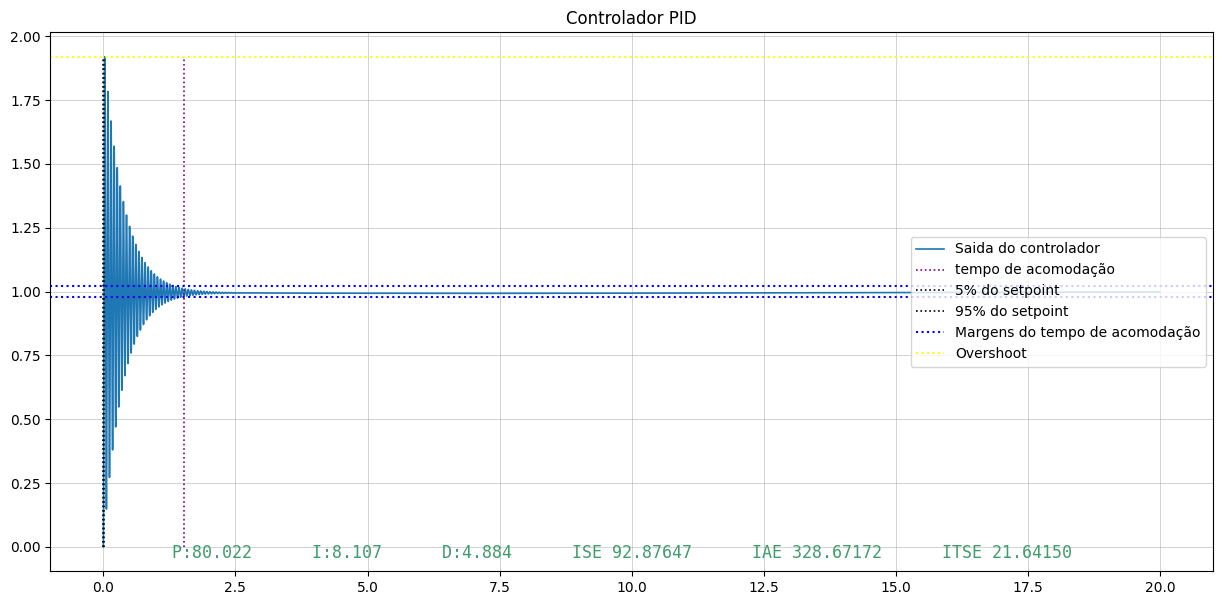

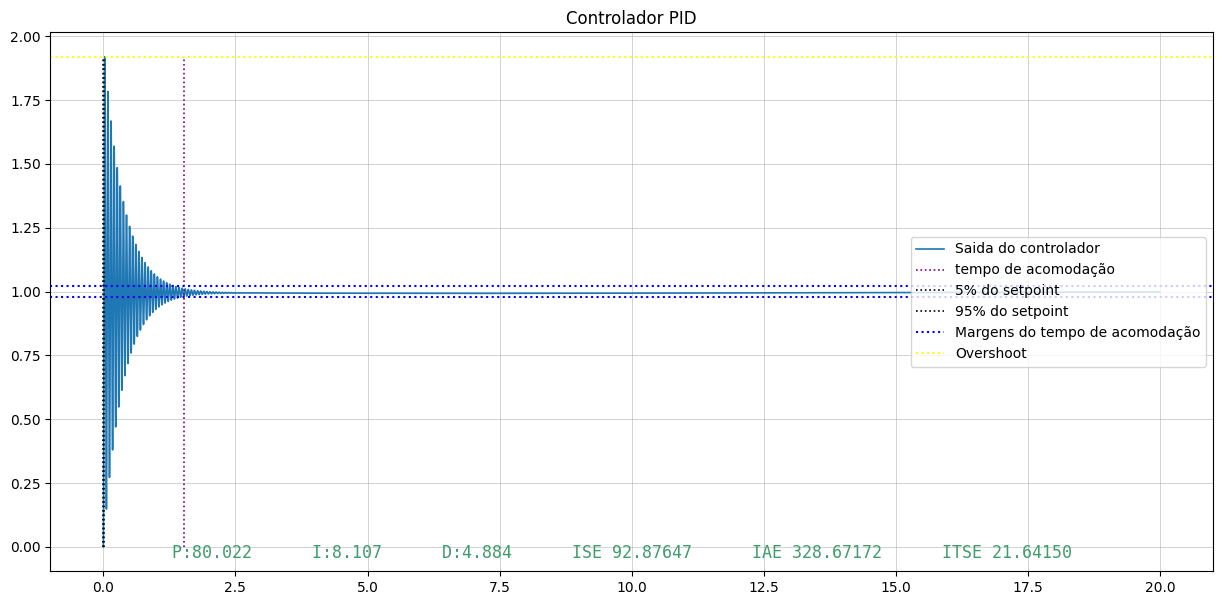

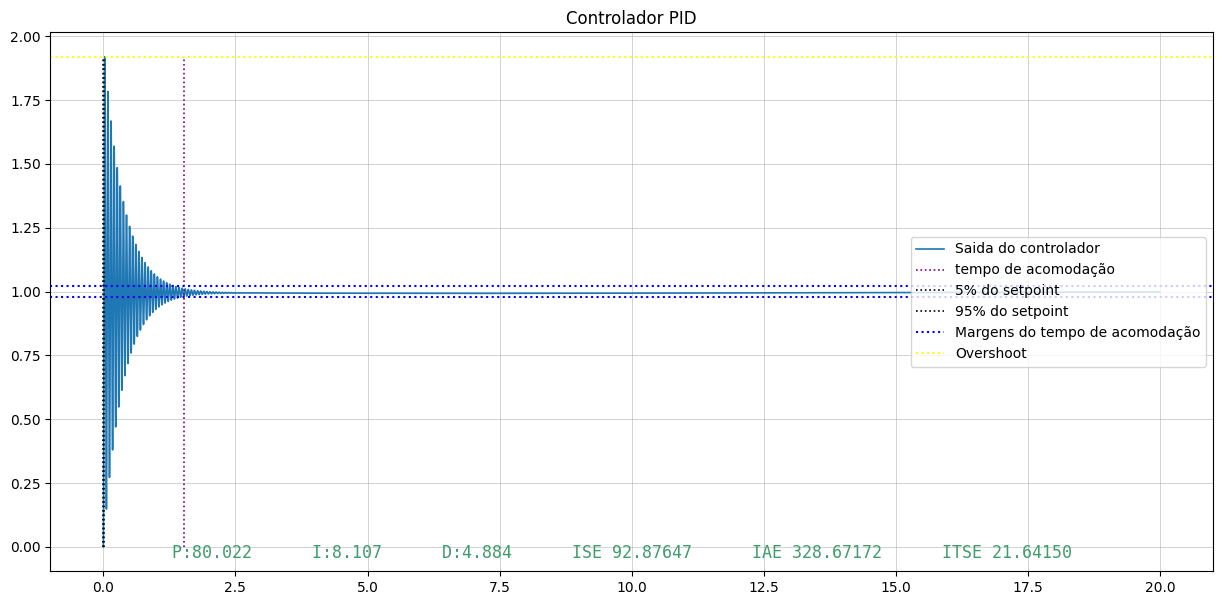

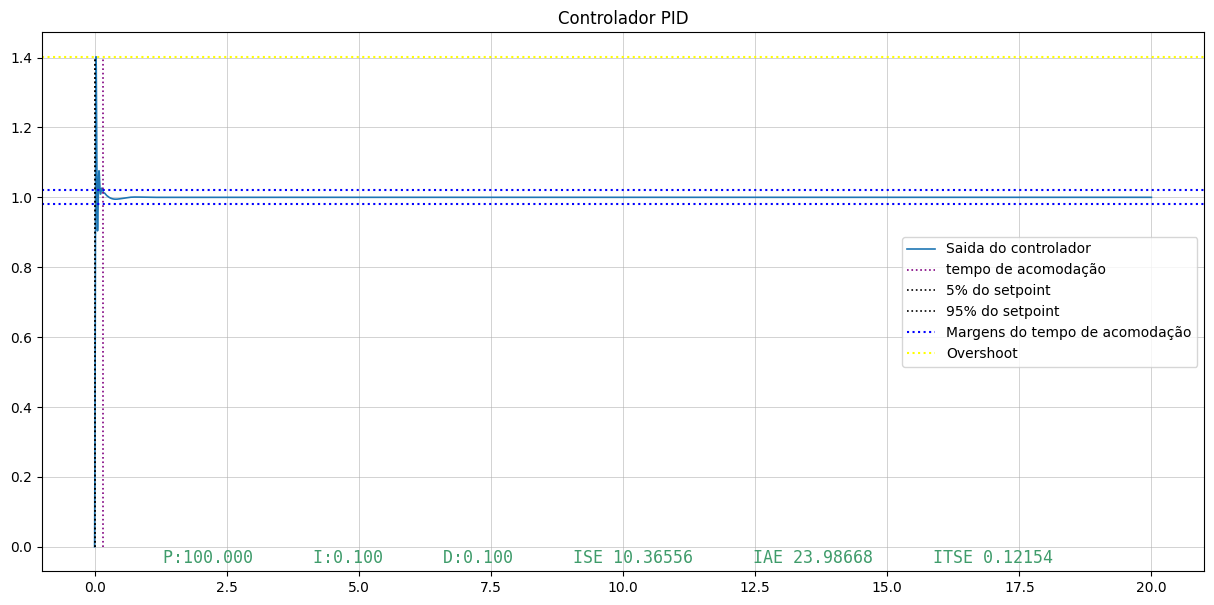

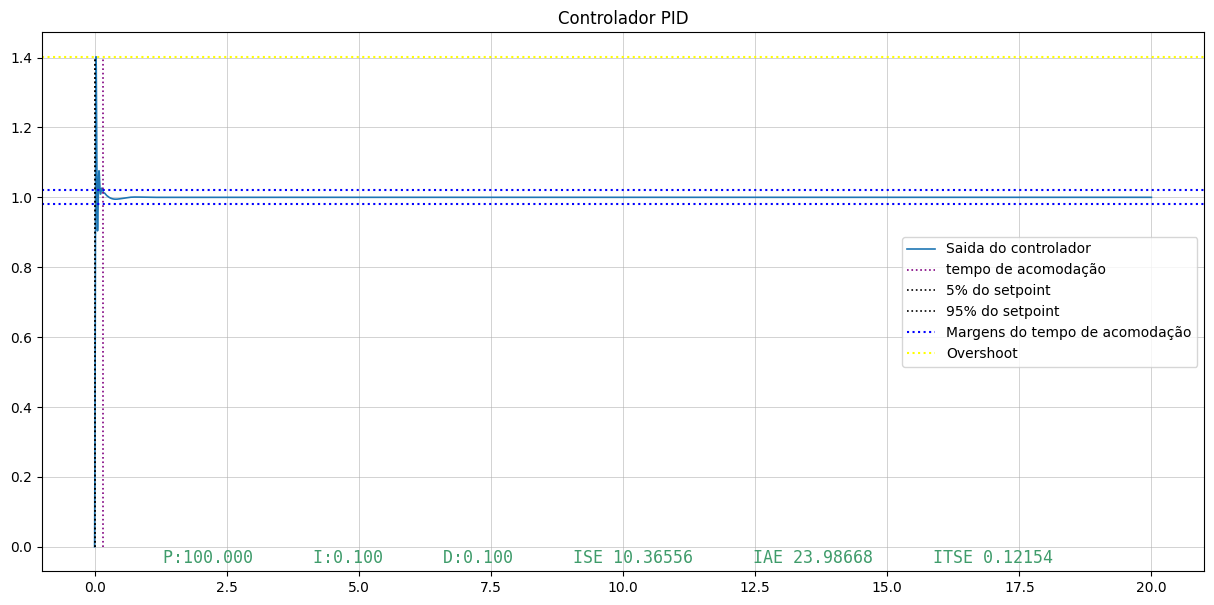

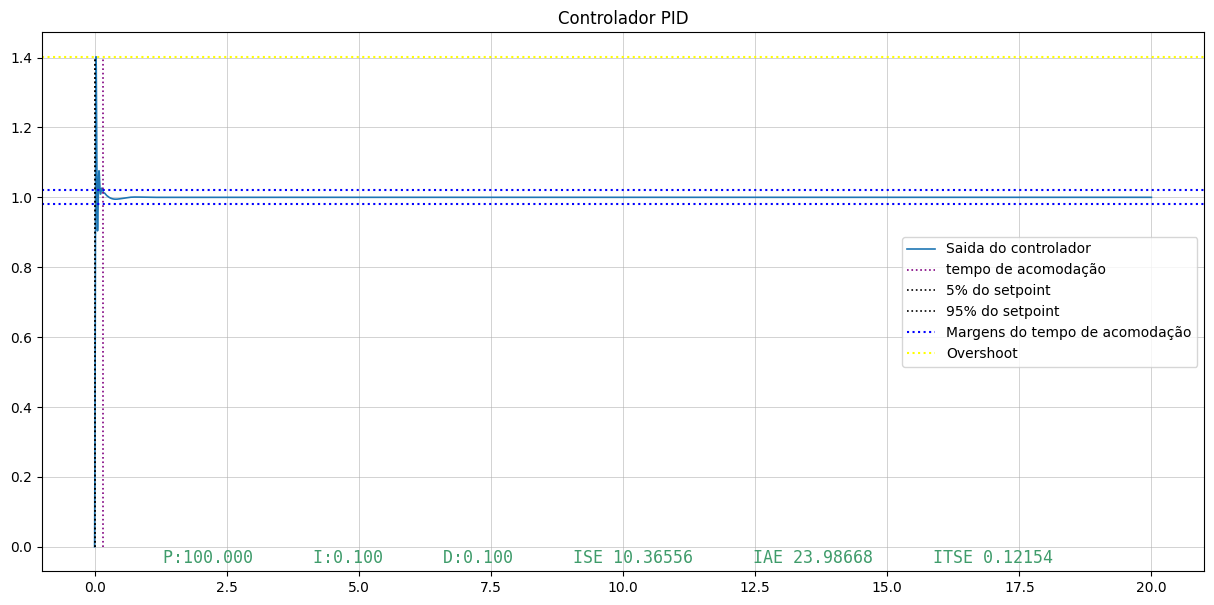

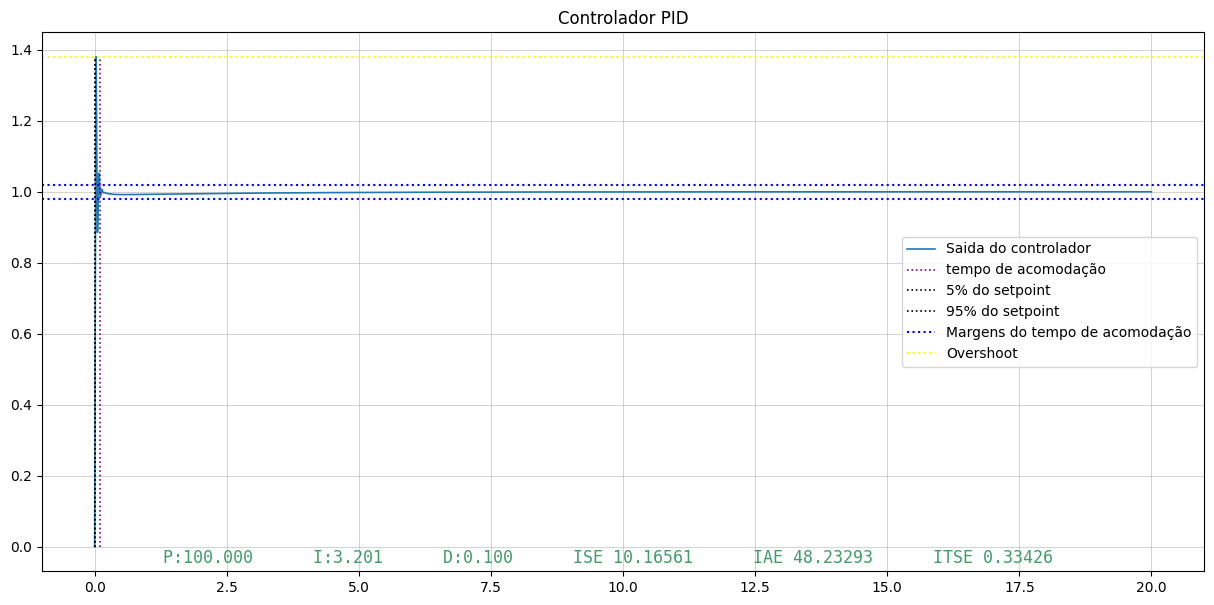

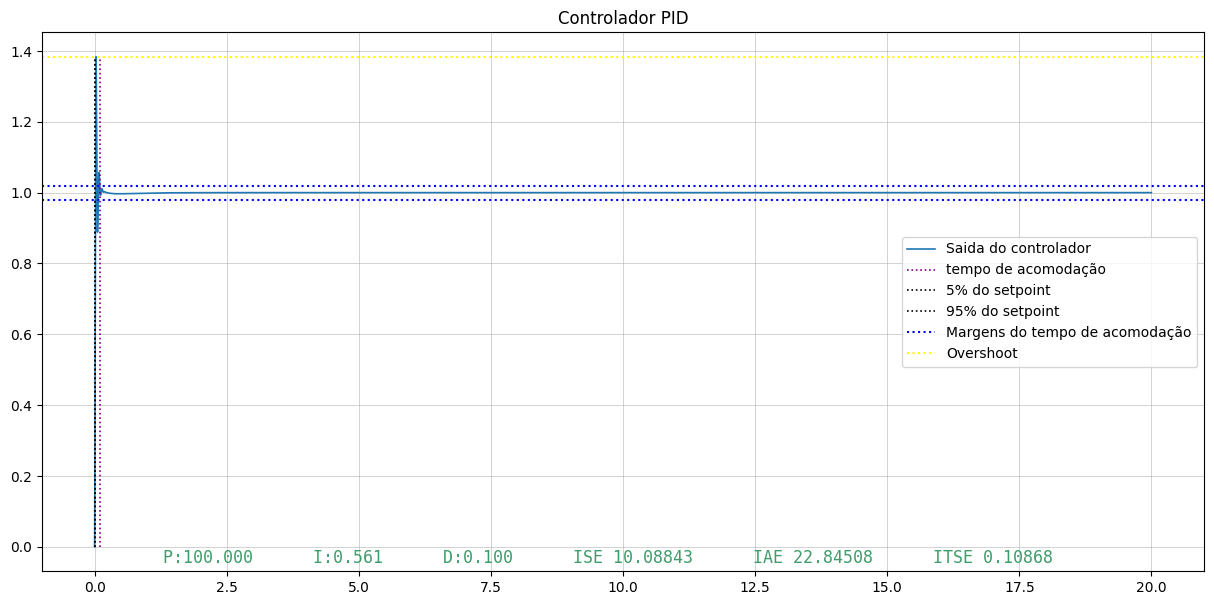

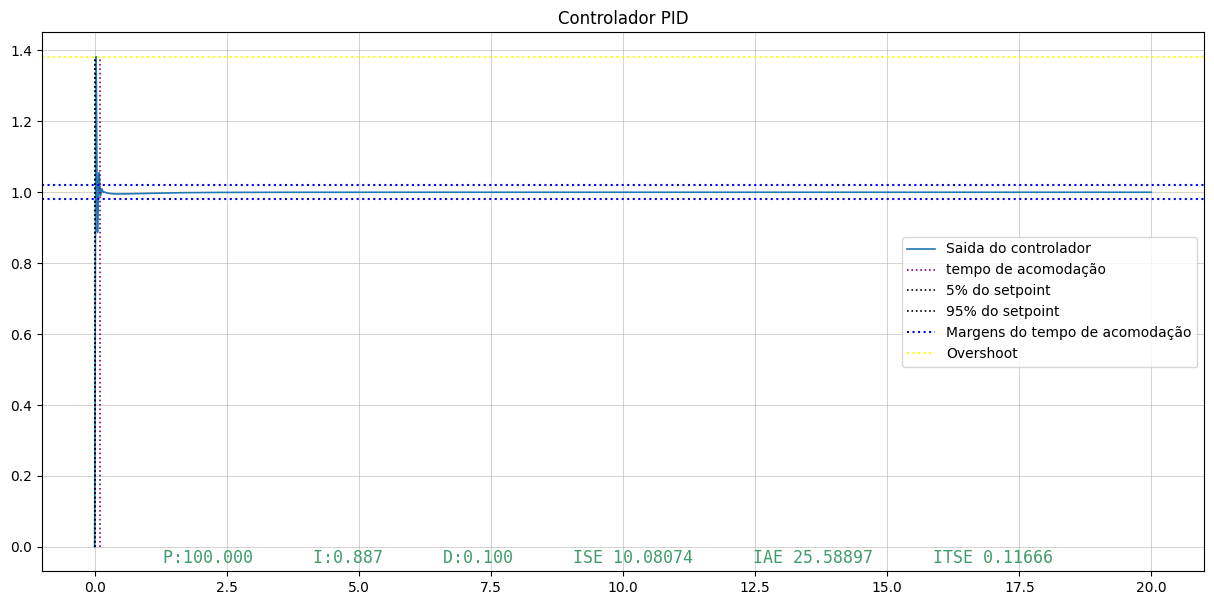

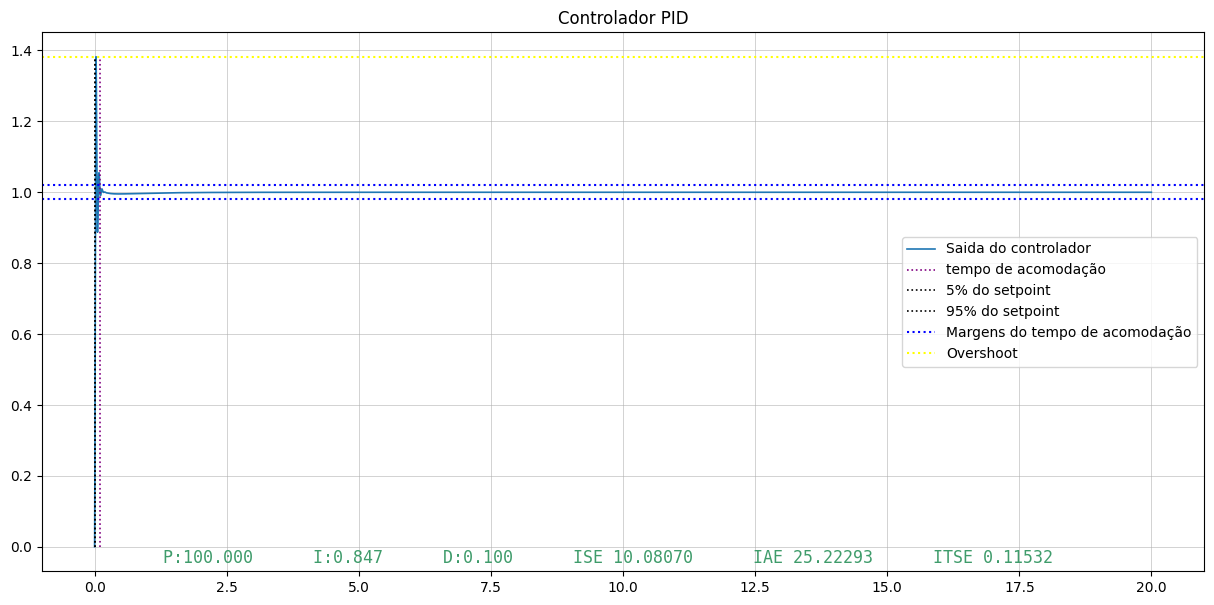

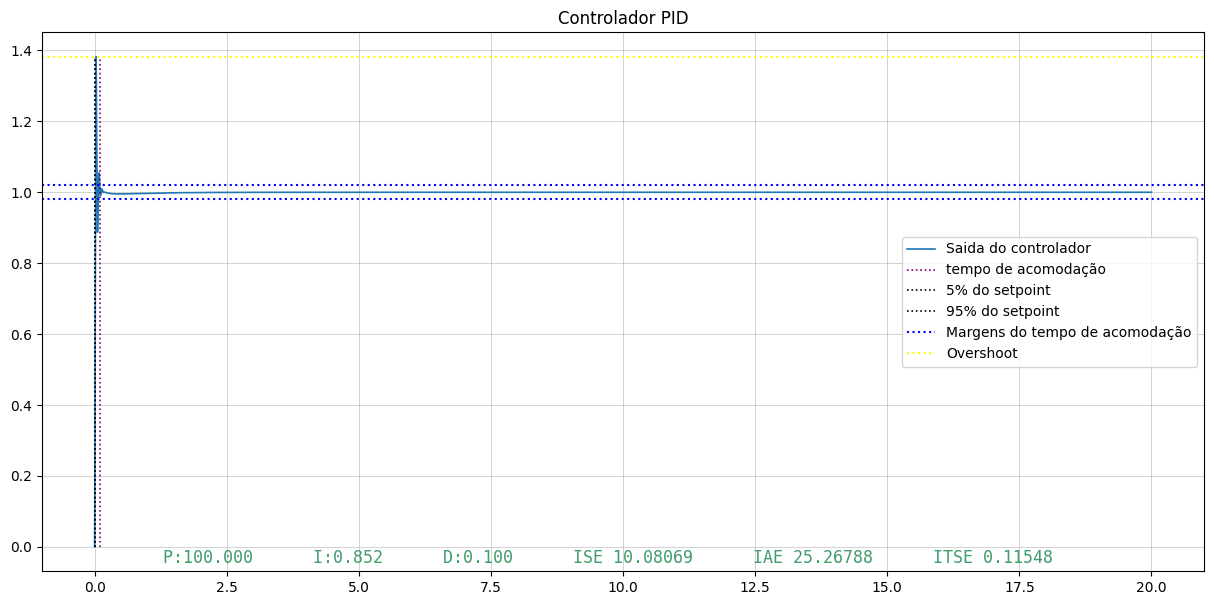

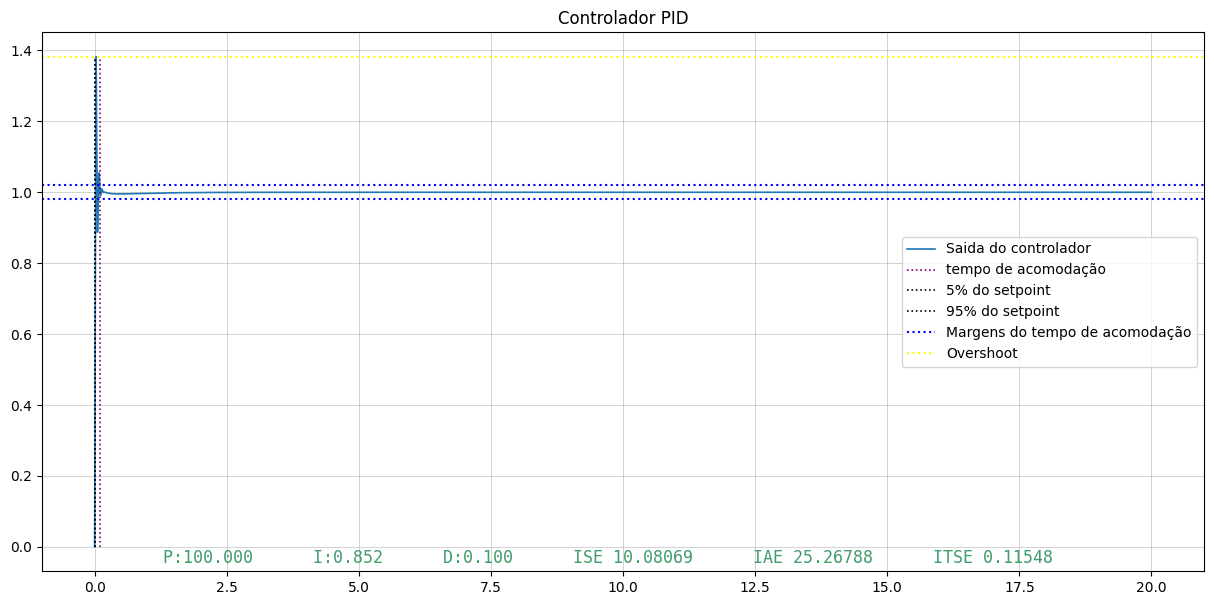

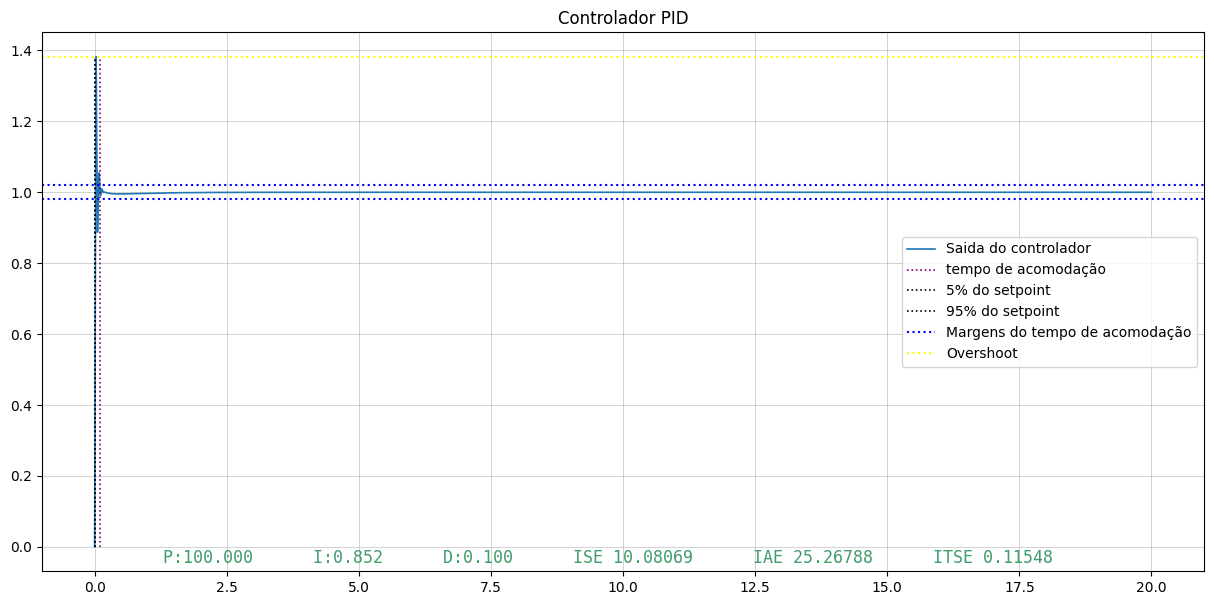

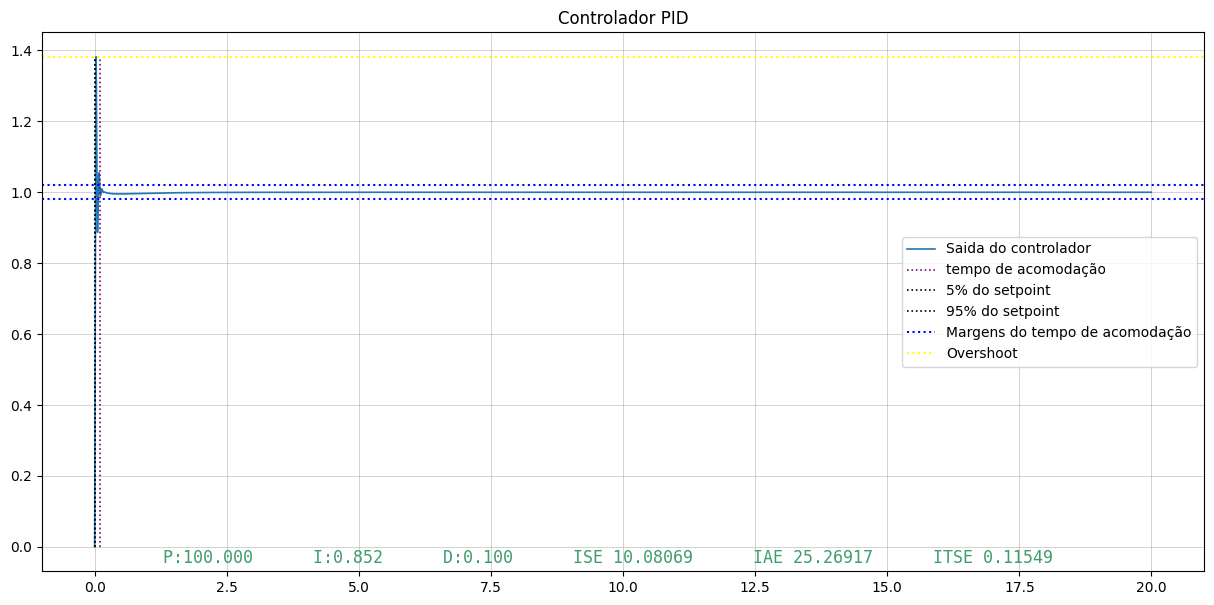

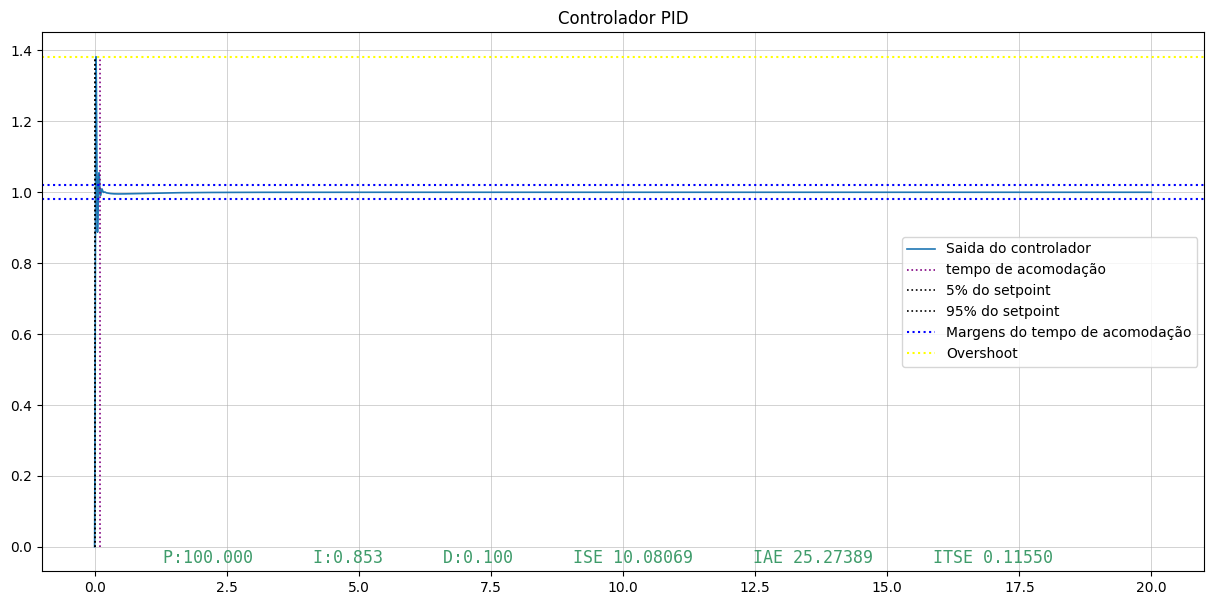

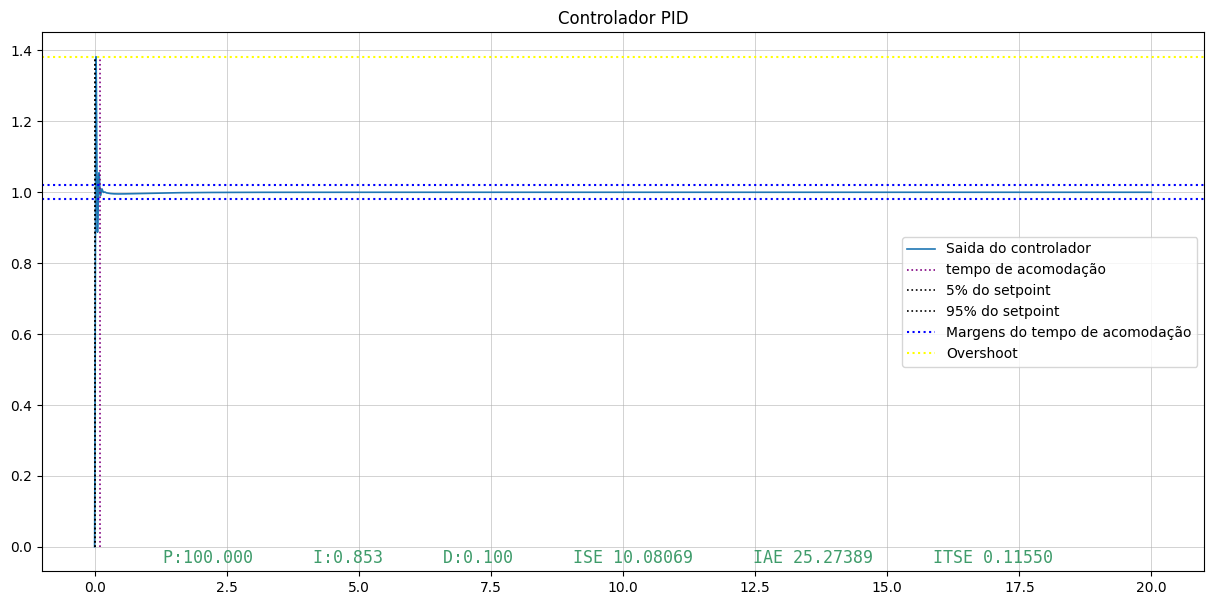

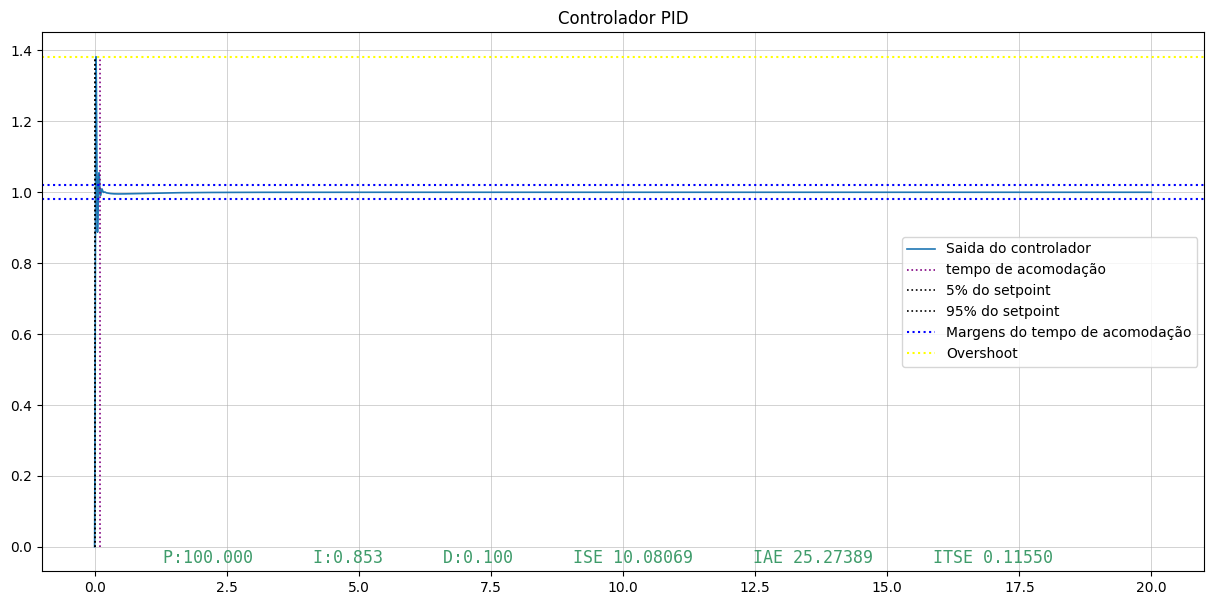

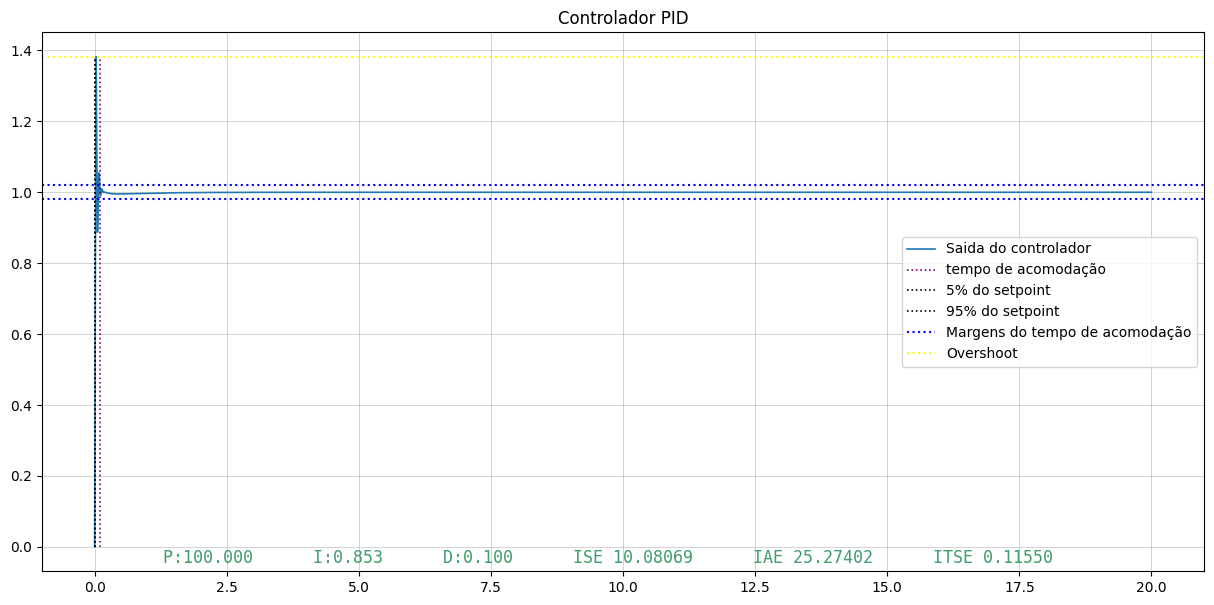

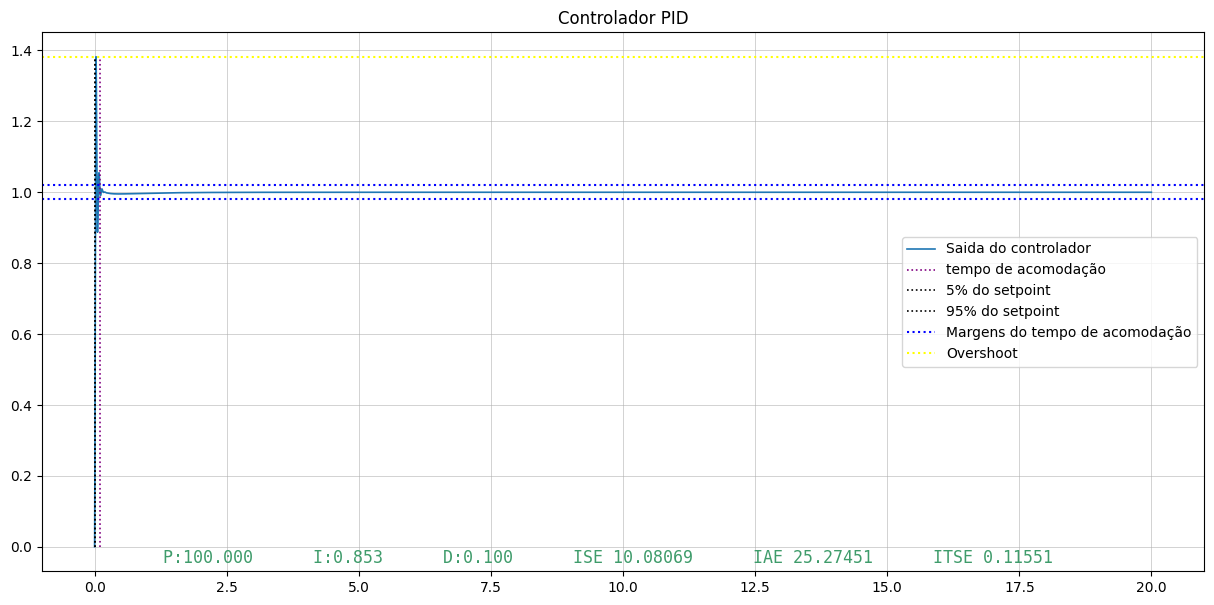

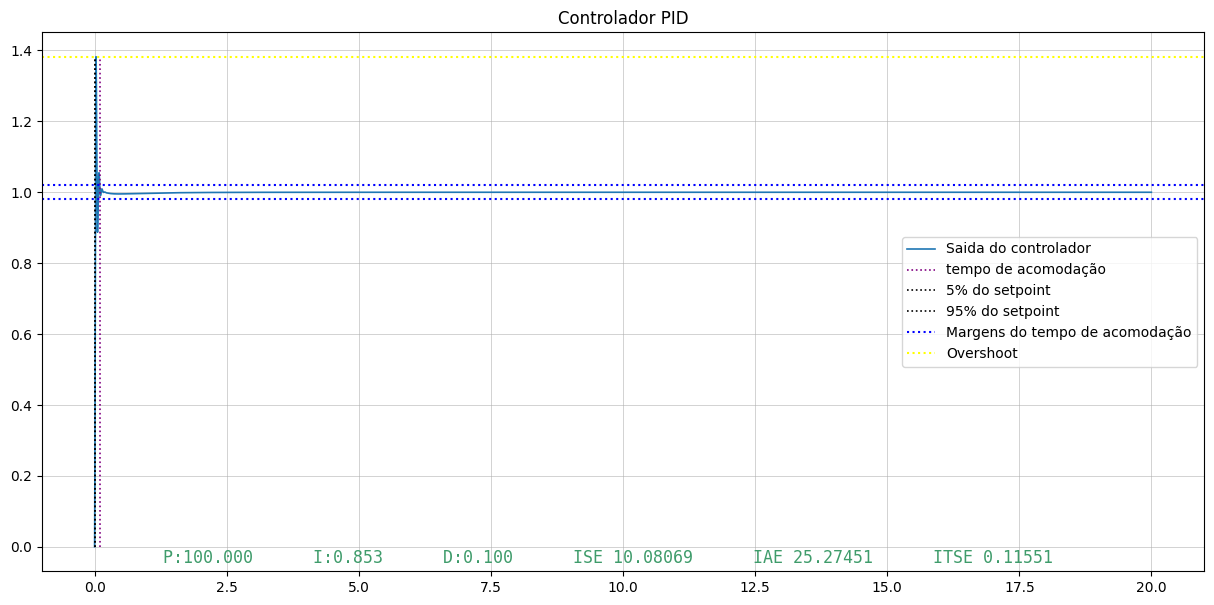

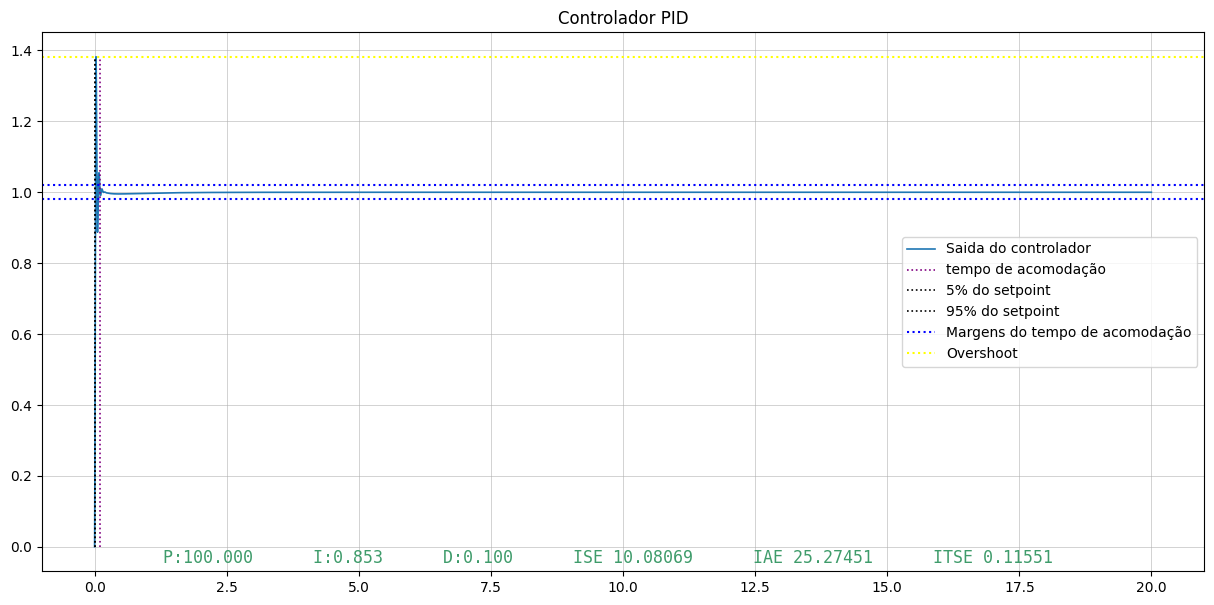

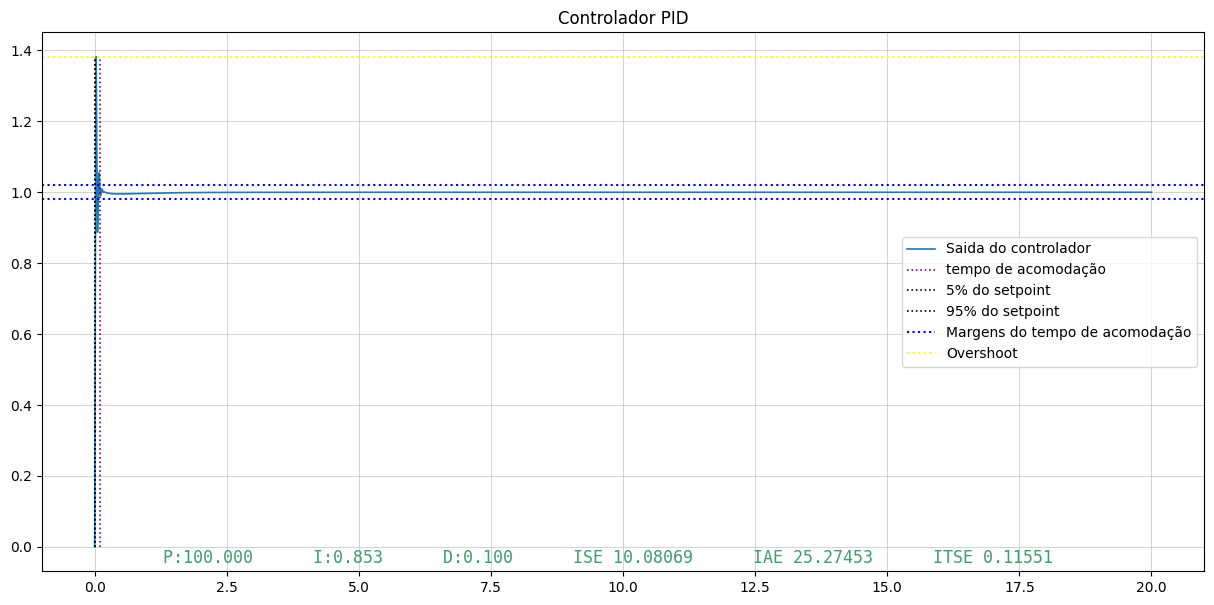

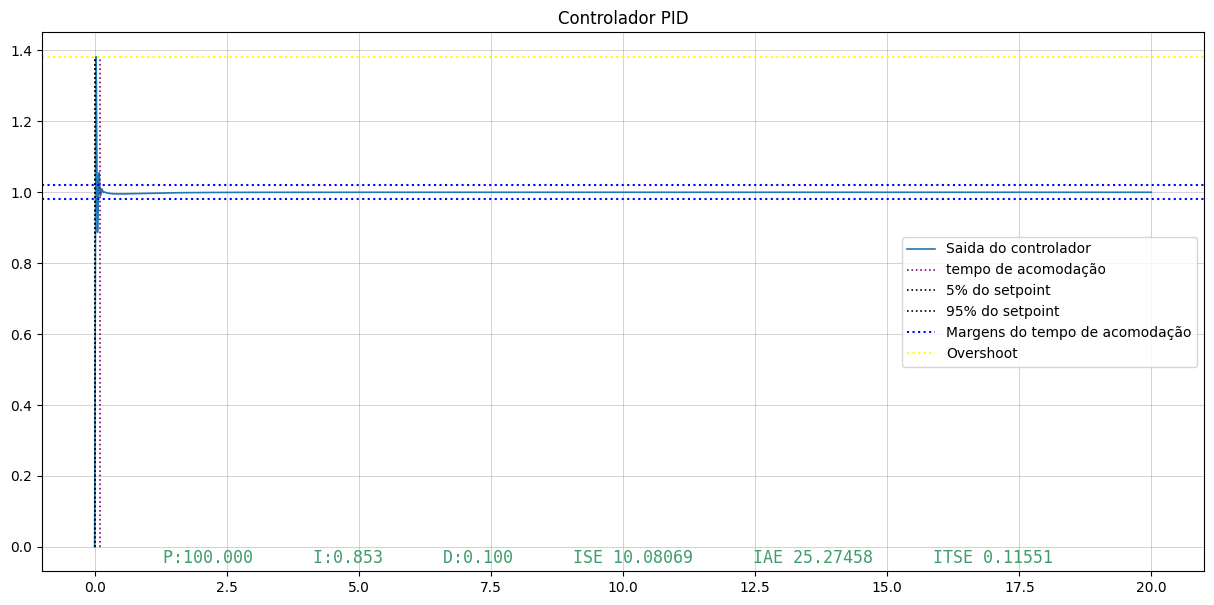

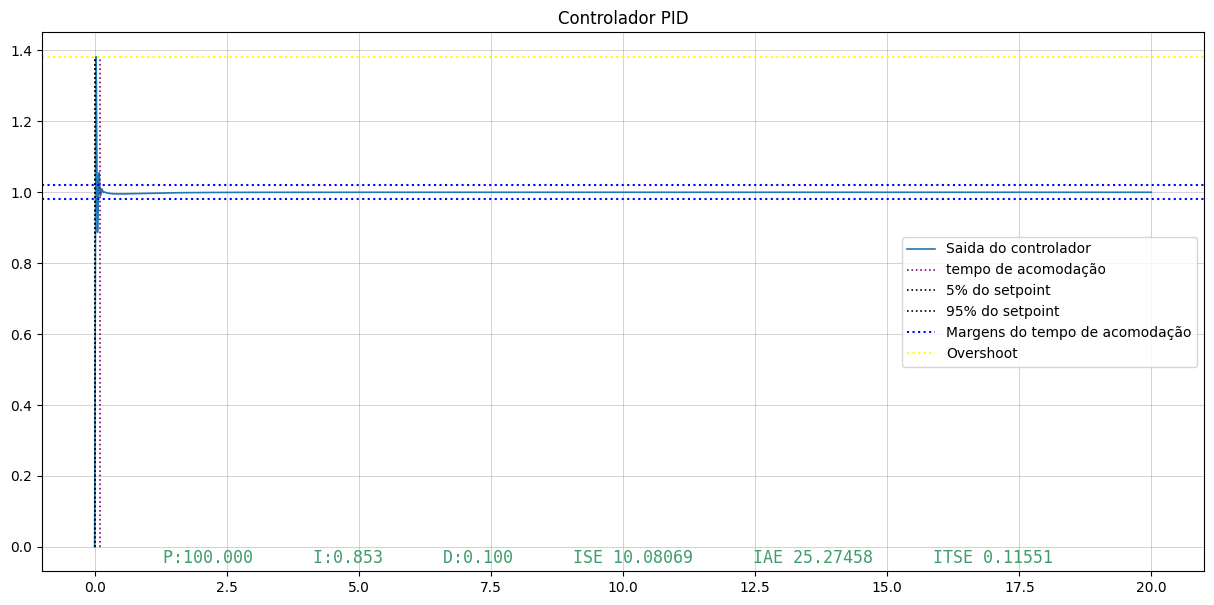

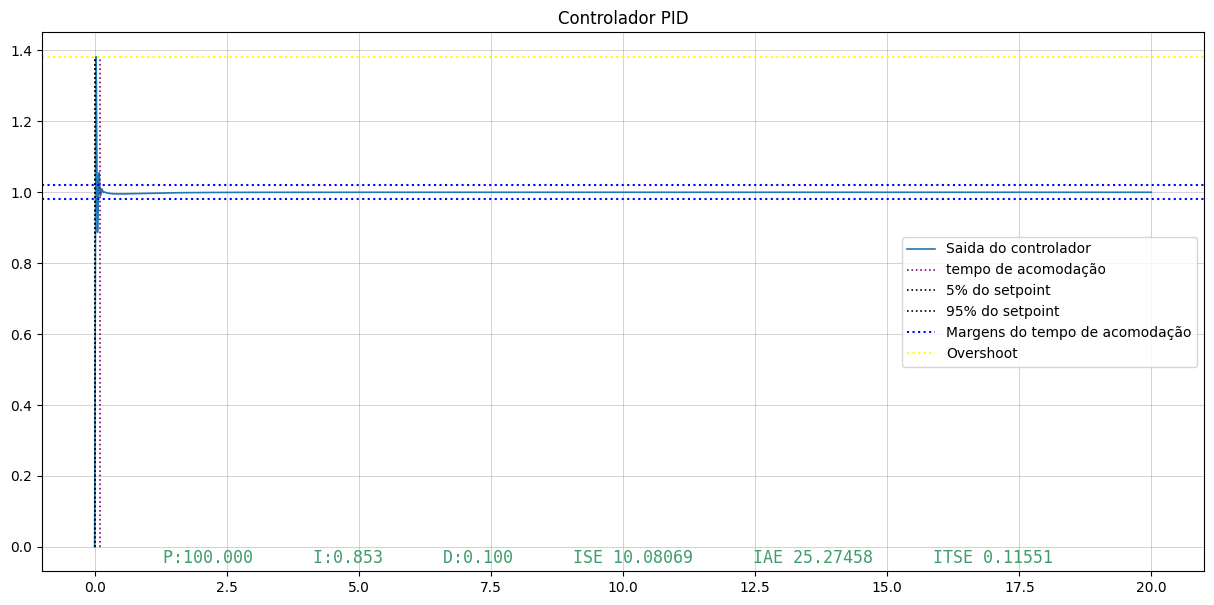

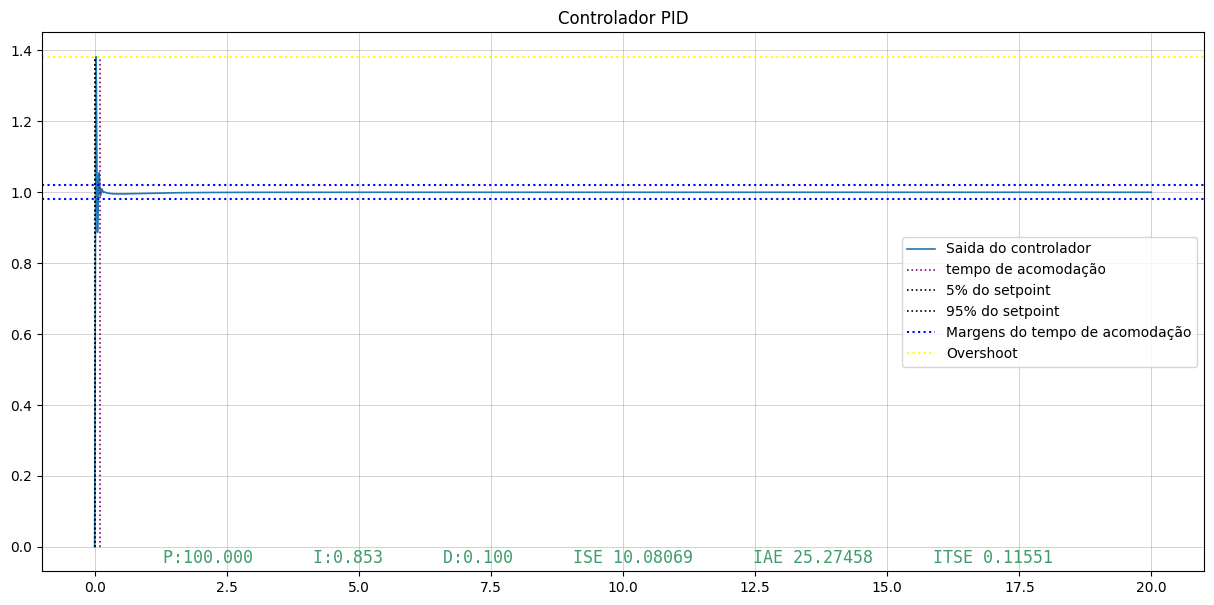

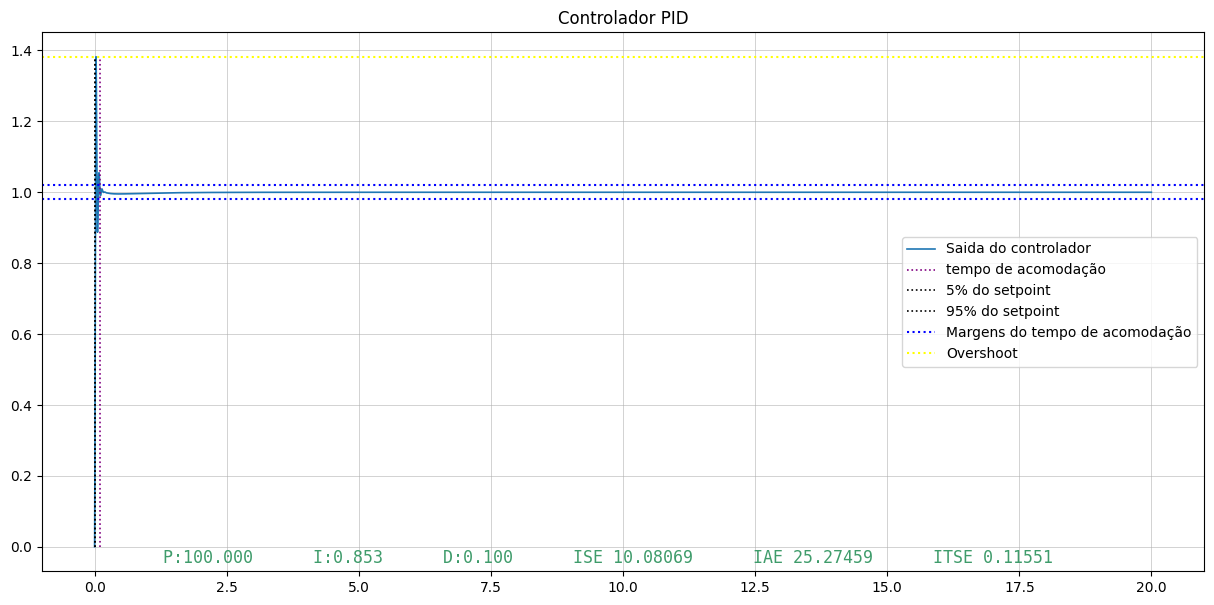

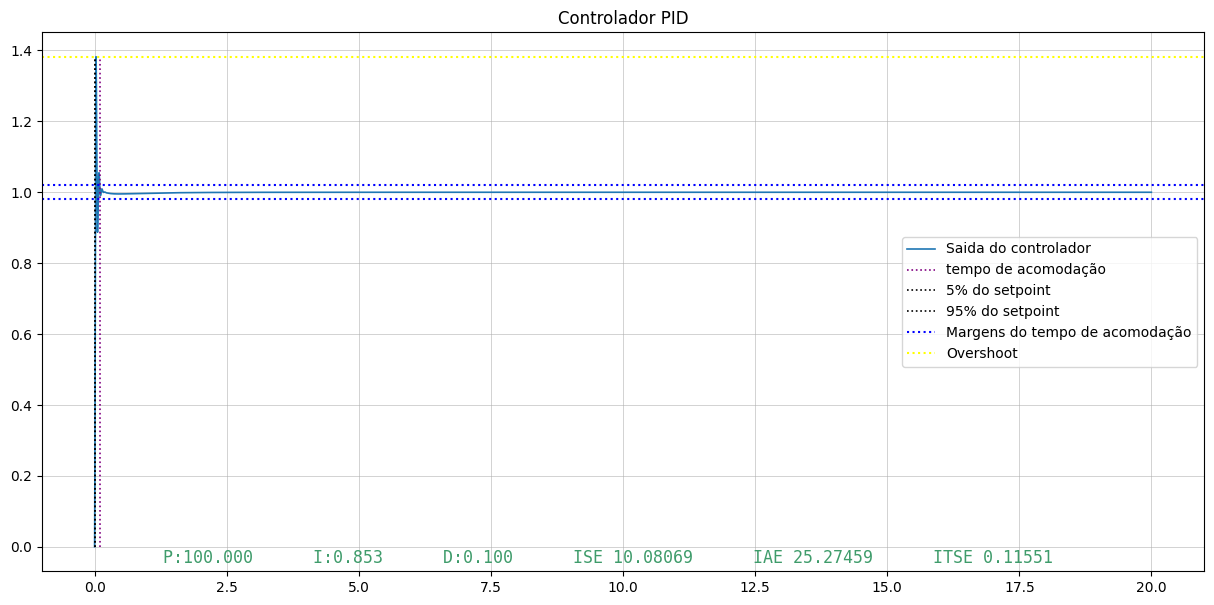

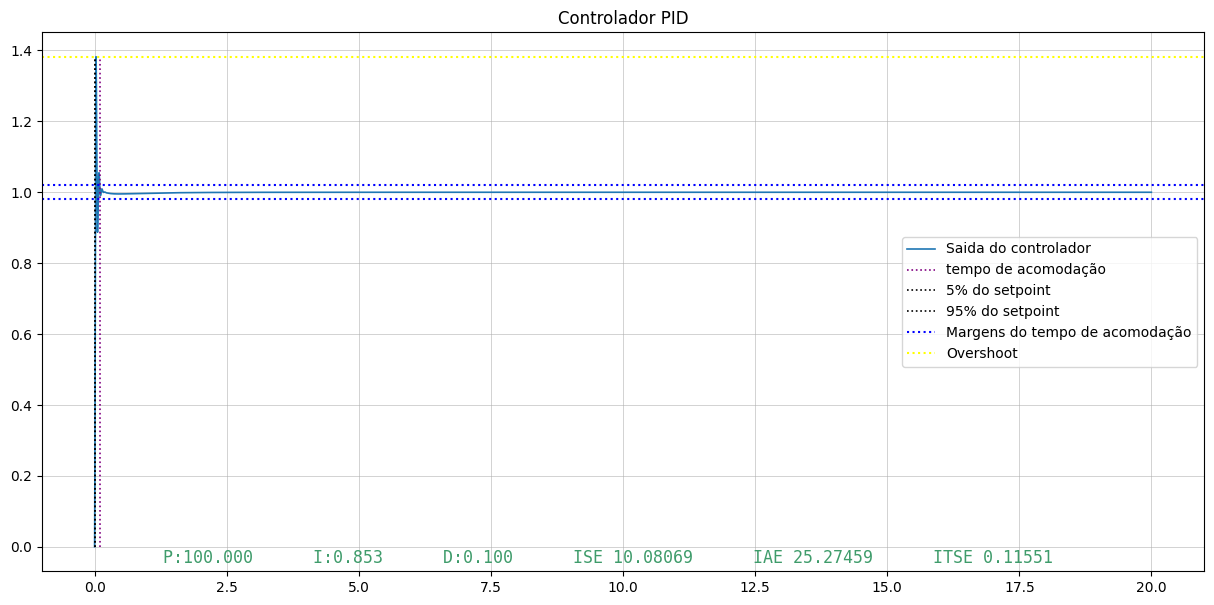

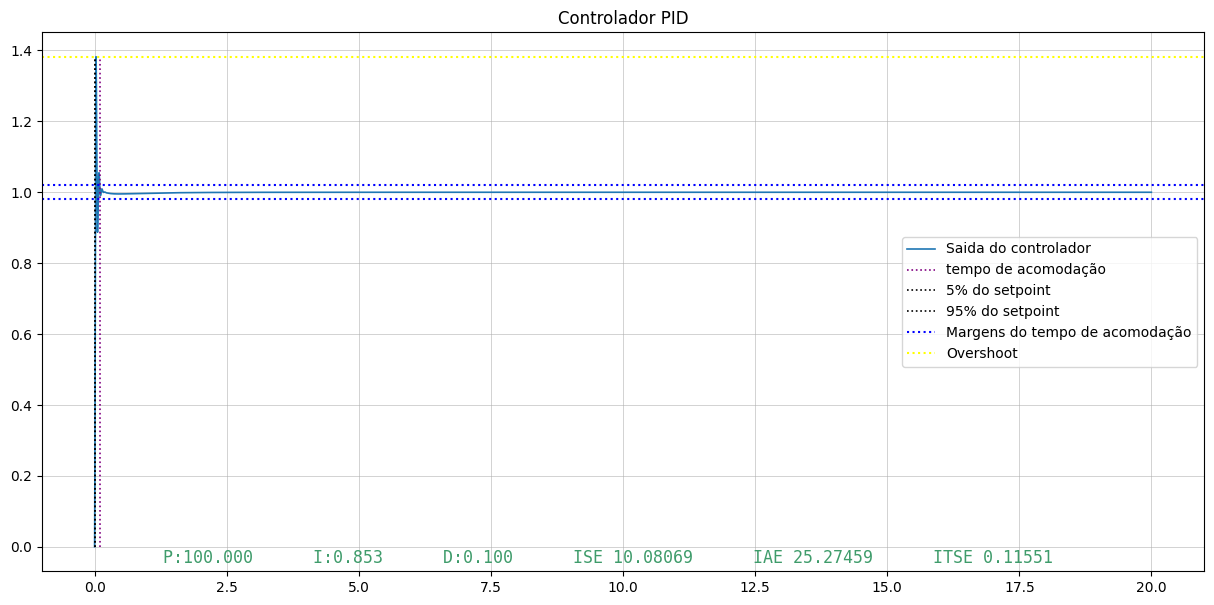

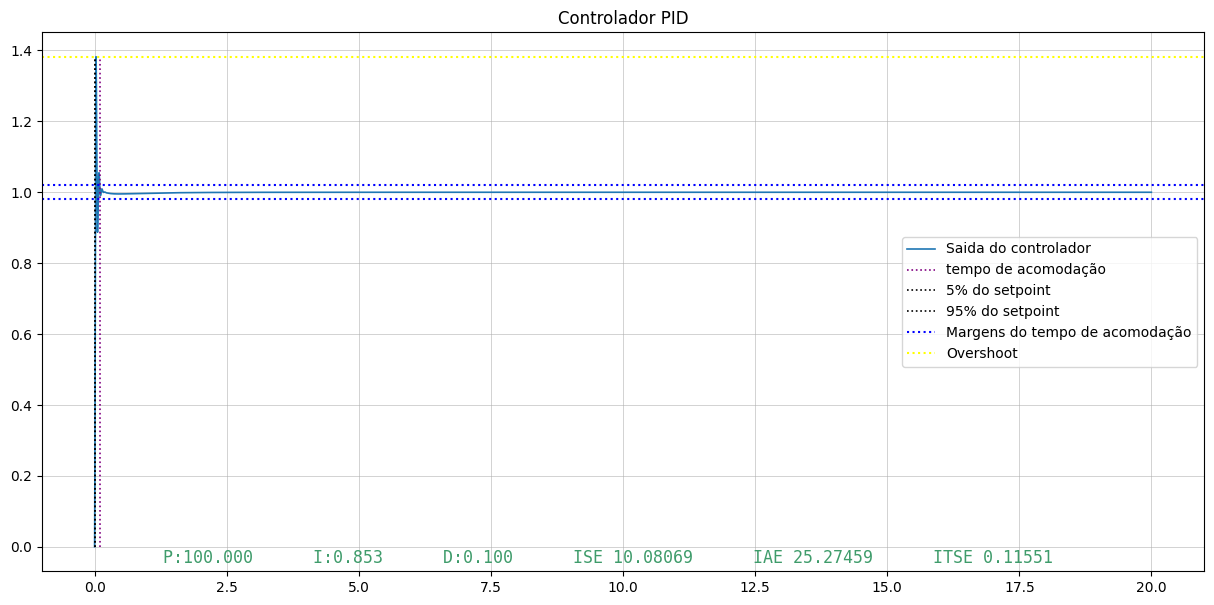

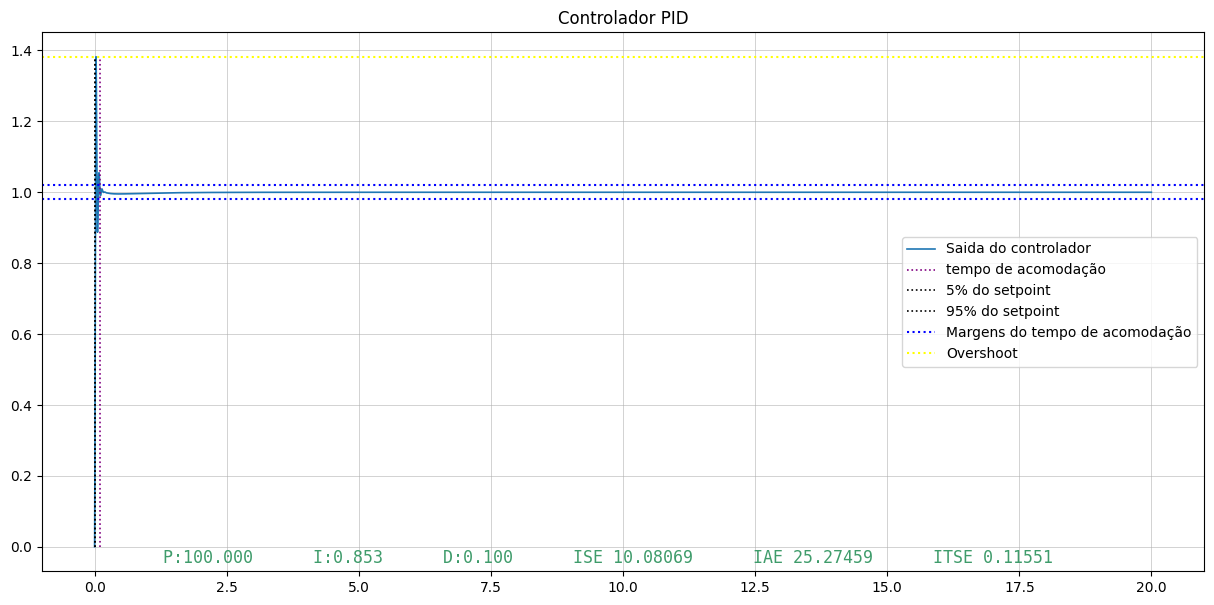

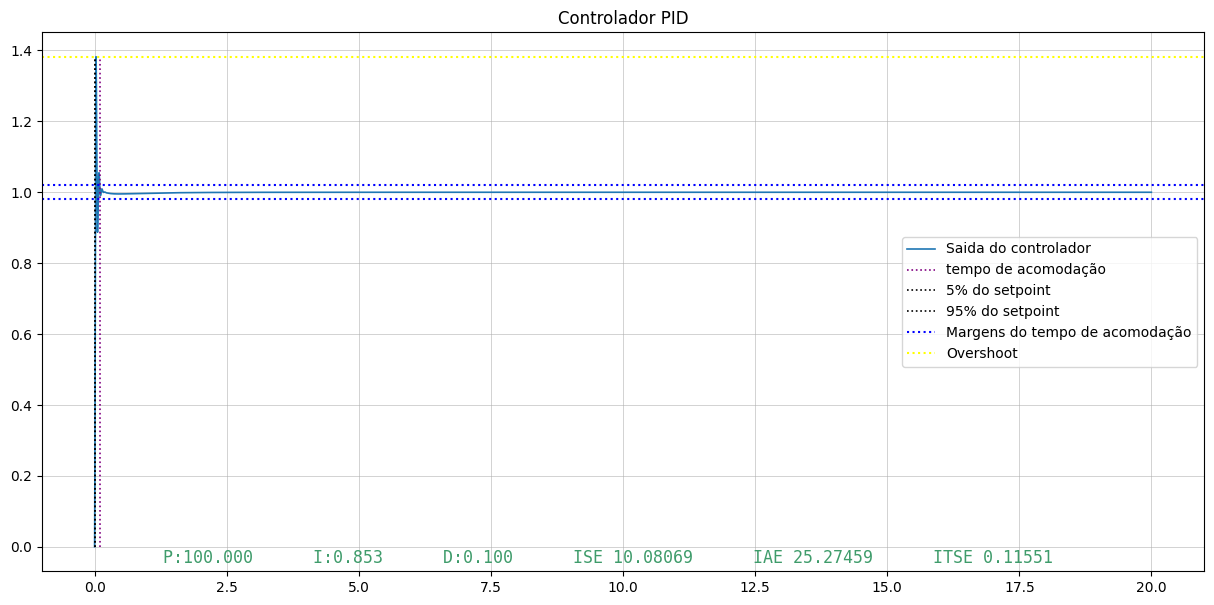

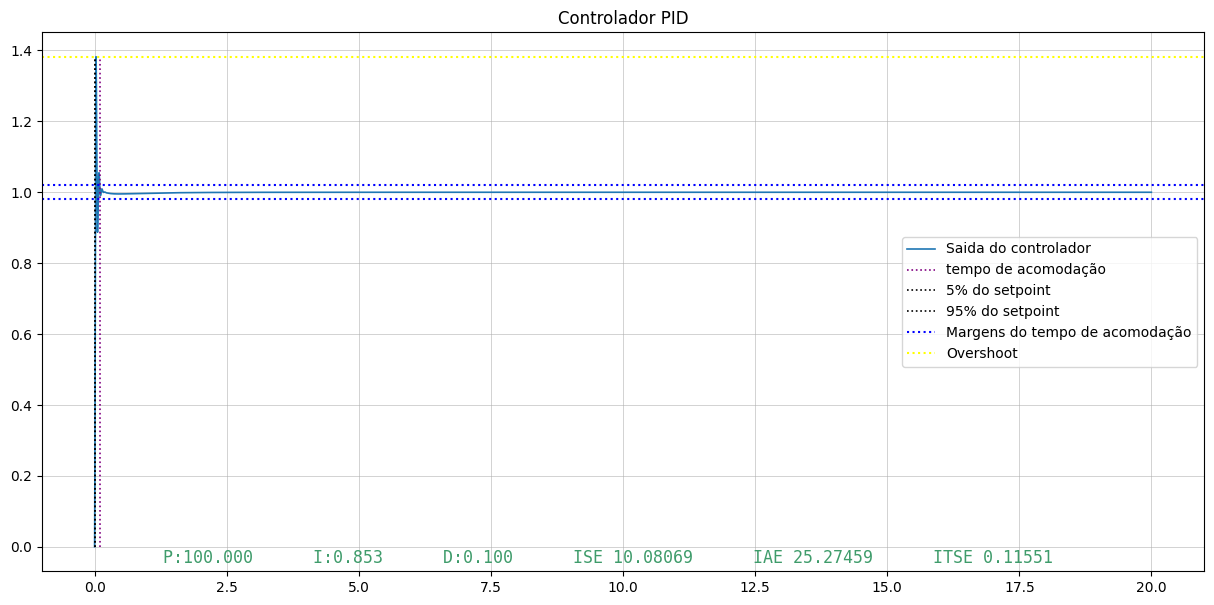

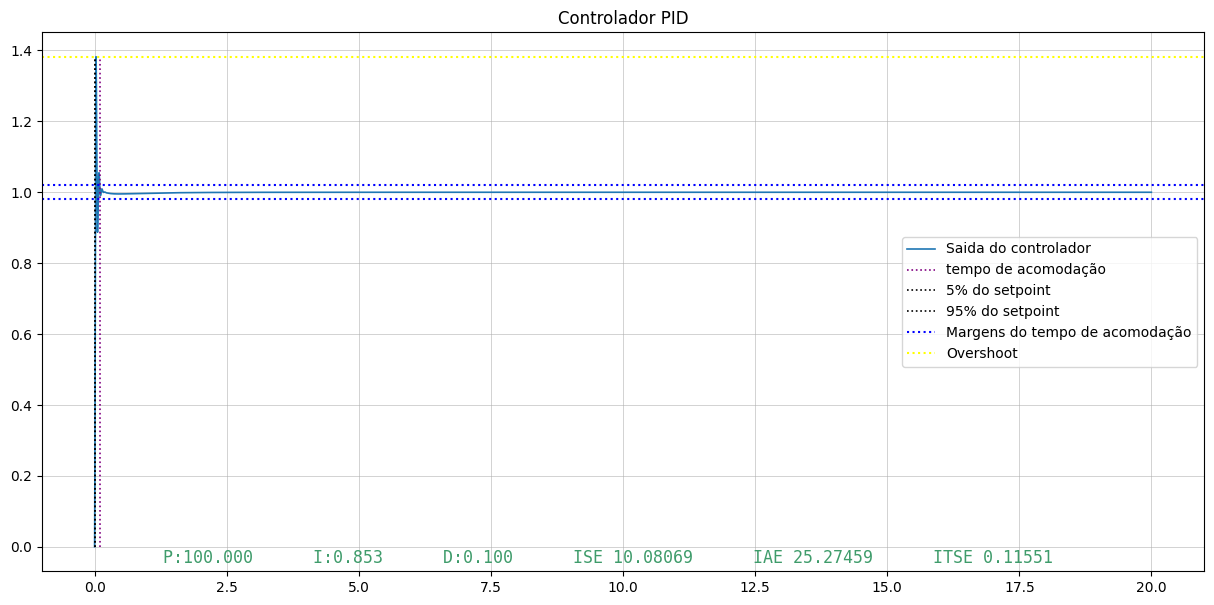


Sem melhoras á 1 iterações



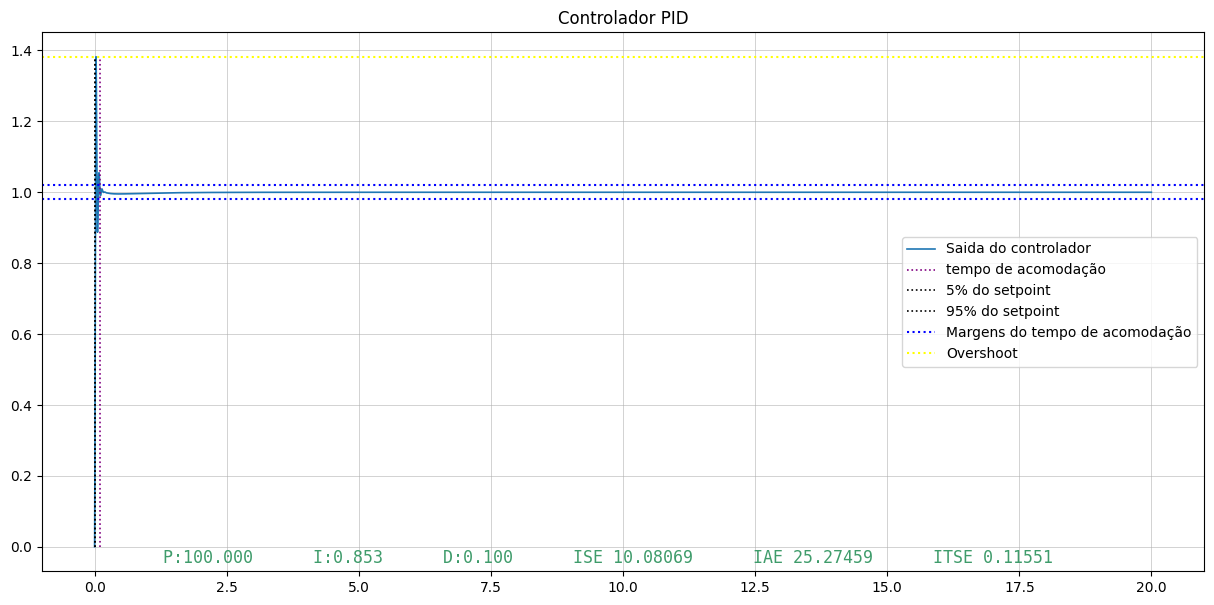


Sem melhoras á 2 iterações



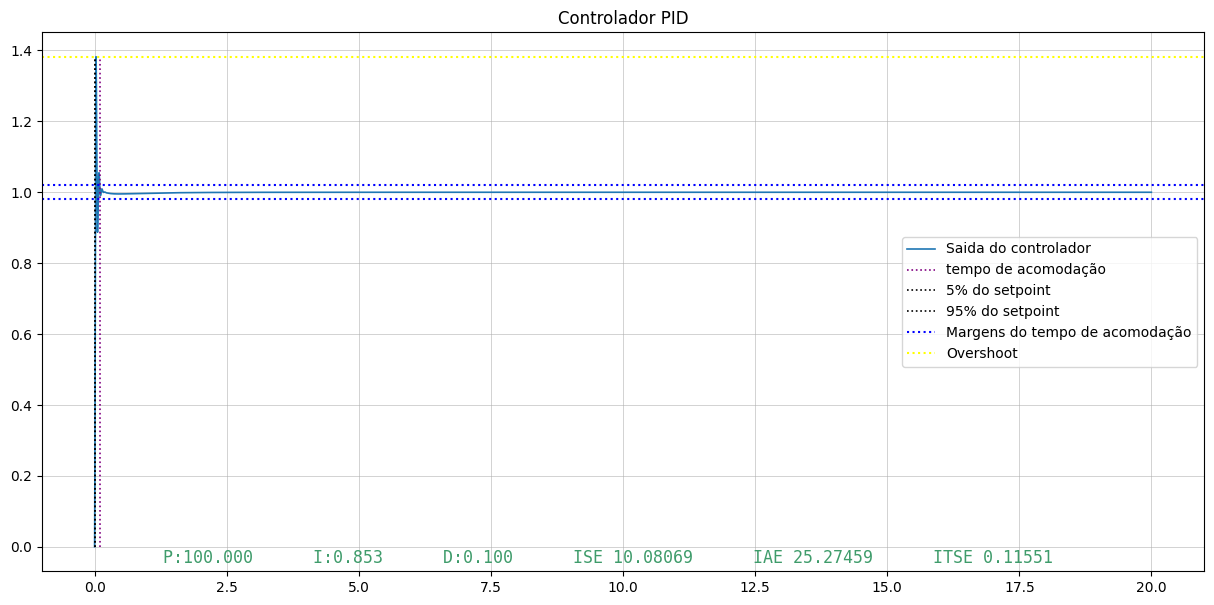


Sem melhoras á 3 iterações



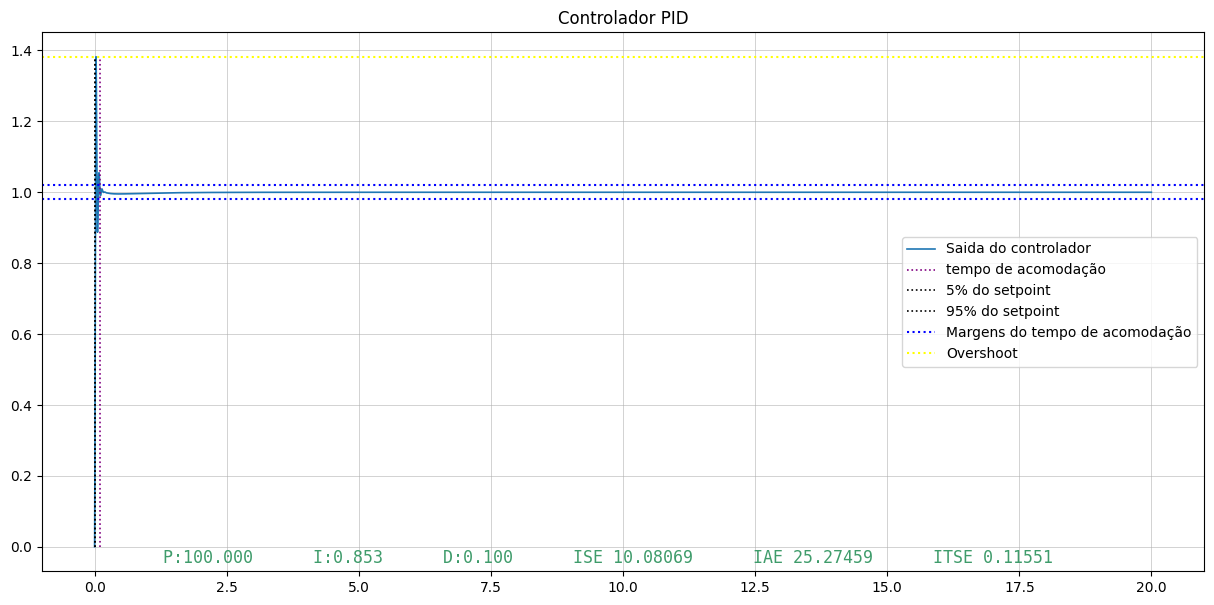


Sem melhoras á 4 iterações



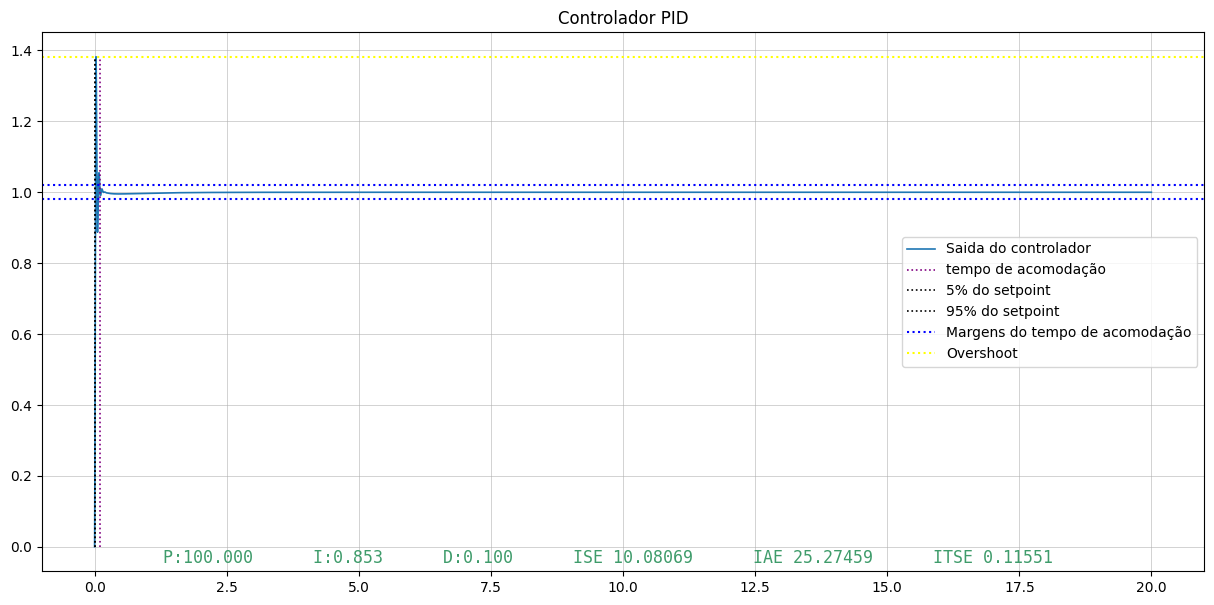


Sem melhoras á 5 iterações

< Critério de parada atingido, o sistemas não teve melhoras significativas a 5 iterações. >
< 40 iterações antes de atingir o critério. >


In [21]:
# melhores coeficientes: w = 0.25, c1 = 1.0, c2 = 0.75  
# melhores coeficientes para o PID: w = 0.5, c1 = 1.0, c2 = 0.75 
# melhores coeficientes para o PID: w = 1.0, c1 = 1.0, c2 = 0.5

num = [16]
den = [1,4,16]
set_point = 1.0

pid_param = list()

w = 1.0 # fator de inercia
c1 = 1.0  # fator cognitivo
c2 = 0.5 # fator social
 
n_part = 10 # numero de particulas
parada = 0.001 # critério de parada
dim = 3 # dimensão da entrada 

min = 0.1 # minimo do sistema
max = 100.0 # maximo do sistema

pid_param.append(num)
pid_param.append(den)
pid_param.append(set_point)

particulas = inicializate(n_part, dim, min, max)  
update_sistem(particulas,min,max,w,c1,c2,parada,dim,pid_param)
  

## Célula de teste

In [22]:
h = Tempo_Subida([100,0.100,0.100],pid_param)
h

(0.002, 0.015)